# Dengue Analysis

In [1]:
# Import essentials
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

Carreguem les dades i les ajuntarem totes en un mateix dataframe (aixi podrem omplir NaNs de tot)

In [2]:
# load the csv
train_values_df = pd.read_csv('dengue_features_train.csv') # Load the `train` file
train_labels_df = pd.read_csv('dengue_labels_train.csv') # Load the `train` file
test_values_df = pd.read_csv('dengue_features_test.csv') # Load the `train` file

#store the original dimensions
len_train=train_values_df.shape[0]
len_test=test_values_df.shape[0]

# el train es train_values + train_labels
train= pd.concat([train_values_df, train_labels_df['total_cases']], axis=1, sort=False)

# el df_TOTAL es tot, train (values + labels) y test concatenat
df_TOTAL = pd.concat([train, test_values_df]).reset_index(drop=True)

# posem les dates en format de dates (aixi al fer plots es mes facil)
df_TOTAL['Date_Start_week'] =  pd.to_datetime(df_TOTAL['week_start_date'], format='%Y-%m-%d')

Mirem els Nans?

In [3]:
# aqui simplement omplim amb valors duesfiles al test que no tenen ni un sol valor de cap variable
df_kk = df_TOTAL[df_TOTAL['city']=='sj']
id_nans_test = df_kk[pd.isnull(df_kk['reanalysis_air_temp_k'])].index.tolist()

df_TOTAL.loc[id_nans_test]

,city,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,week_start_date,weekofyear,year,Date_Start_week
87,sj,0.1251,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,81.0,1992-01-01,1,1992,1992-01-01
139,sj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,30.0,1993-01-01,53,1993,1993-01-01
399,sj,0.0455,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,64.0,1998-01-01,1,1998,1998-01-01
451,sj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,1999-01-01,53,1999,1999-01-01
711,sj,-0.2683,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15.0,2004-01-01,1,2004,2004-01-01
763,sj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,2005-01-01,53,2005,2005-01-01
1491,sj,0.5004,0.161425,0.160786,0.188650,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01,1,2009,2009-01-01
1543,sj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01,53,2010,2010-01-01


les dues ultimes (setmana 1 i 53) son de test, i omplirem dades amb els promitjos de la mateixa setmana per altres anys

In [4]:
kk1 = df_kk[df_kk['weekofyear']==1].mean(axis=0)
kk53 = df_kk[df_kk['weekofyear']==52].mean(axis=0)

list_to_fill_53 = ['ndvi_ne', 'ndvi_nw','ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']

list_to_fill_1 = ['precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm']

for i in list_to_fill_1:
    df_TOTAL[i][id_nans_test[-1]] = kk1[i]
    
for i in list_to_fill_53:
    df_TOTAL[i][1491] = kk53[i]

In [5]:
del [kk1,kk53,list_to_fill_53,list_to_fill_1,df_kk]

Ara eliminem les setmanes que tenen tot NaNs (podriem mirar d'omplir-les amb dades?)

In [6]:
# Aqui ara eliminem del dataframe les setmanes que tenen tot NaNs (son les mateixes que tenen reanalisis NAN), del train eh (al test no les podem aliminar)
id_drop= df_TOTAL[pd.isnull(df_TOTAL['reanalysis_air_temp_k'])].index.tolist()

#eliminem del datframe i dels labels
df_TOTAL = df_TOTAL.drop(id_drop,axis=0)
train_labels_df = train_labels_df.drop(id_drop,axis=0)

#### Passem Temperatures de Kelvin a Celsius? aixi estan totes igual
* segurament no importa, perque despres ho estandaritzem...pero per si de cas

In [7]:
# passem a ºC totes les que estan en K
df_TOTAL['reanalysis_air_temp_c']=df_TOTAL['reanalysis_air_temp_k'] - 273.15
df_TOTAL['reanalysis_max_air_temp_c']=df_TOTAL['reanalysis_max_air_temp_k'] - 273.15
df_TOTAL['reanalysis_min_air_temp_c']=df_TOTAL['reanalysis_min_air_temp_k'] - 273.15
df_TOTAL['reanalysis_dew_point_temp_c']=df_TOTAL['reanalysis_dew_point_temp_k'] - 273.15
df_TOTAL['reanalysis_avg_temp_k']=df_TOTAL['reanalysis_avg_temp_k'] - 273.15

df_TOTAL = df_TOTAL.drop(columns=['reanalysis_air_temp_k','reanalysis_max_air_temp_k','reanalysis_min_air_temp_k',
                                  'reanalysis_dew_point_temp_k','reanalysis_avg_temp_k'])

En aquest grafic veiem com algunes variables tenen correlacions de 1 entre elles, aquestes les podem eliminar ja que venen a ser el mateix:
    * reanalysis_sat_precip_amt_mm i precipitation_amt_mm --> eliminem reanalysis
    * reanalysis_specific_humidity_g_per_kg i reanalysis_dew_point_temp_c --> eliminem dew_point
A part, els NDVI veiem com els nw i ne estan correlacionats (0.85) i sw i sw amb 0.82.
    * Podriem crear una nova que sigui ndvi_n i ndvi_s amb el valor mig dels dos que corresponen, aixi eliminem bastants Nans. 
    * els NaNs que quedin ja veurem com els eliminem

In [8]:
df_TOTAL = df_TOTAL.drop(columns=['reanalysis_sat_precip_amt_mm','reanalysis_sat_precip_amt_mm','week_start_date'])

In [9]:
df_TOTAL['ndvi_N']=df_TOTAL[['ndvi_nw','ndvi_ne']].mean(axis=1)
df_TOTAL['ndvi_S']=df_TOTAL[['ndvi_sw','ndvi_se']].mean(axis=1)

df_TOTAL=df_TOTAL.drop(columns=['ndvi_nw','ndvi_ne','ndvi_sw','ndvi_se'])

### 1) station_avg_temp_c a partir dereanalysis_air_temp_c (0.62 de correlacio lineal)
* te mes correlacio amb altres variables, pero els errors a l'aplicar model son mes alts

Mean Square error: 0.5065357816415449


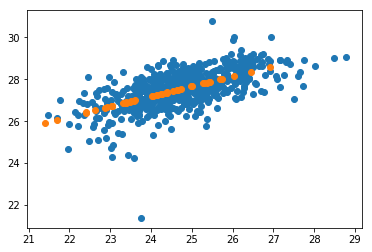

In [10]:
train_iq=df_TOTAL[df_TOTAL['city']=='iq']

id_missing= train_iq[pd.isnull(train_iq['station_avg_temp_c'])].index.tolist()

xx = train_iq['reanalysis_air_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
yy=train_iq['station_avg_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
xx_test=train_iq['reanalysis_air_temp_c'][id_missing].values.reshape(-1,1)


LR=LinearRegression()

results = cross_val_score(LR, xx, yy, cv=6, scoring='neg_mean_squared_error')
print('Mean Square error:',(-results.mean()))

#train model and predict
LR.fit(xx,yy)
pred=LR.predict(xx_test)

#fem un plot
plt.scatter(xx,yy)
plt.scatter(xx_test,pred)
plt.show()

# ho posem on toca
df_TOTAL['station_avg_temp_c'][id_missing] = pred[:,0]

### 2) station_max_temp_c a partir de reanalysis_max_air_temp_c

Mean Square error: 1.154173218978135


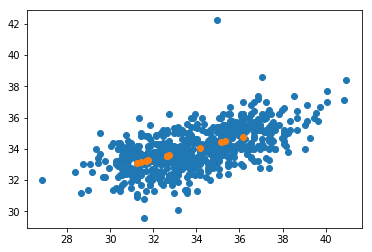

In [11]:
## repetim per maxim
id_missing= train_iq[pd.isnull(train_iq['station_max_temp_c'])].index.tolist()
xx = train_iq['reanalysis_max_air_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
yy=train_iq['station_max_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
xx_test=train_iq['reanalysis_max_air_temp_c'][id_missing].values.reshape(-1,1)

results = cross_val_score(LR, xx, yy, cv=6, scoring='neg_mean_squared_error')
print('Mean Square error:',(-results.mean()))

#predict
LR.fit(xx,yy)
pred=LR.predict(xx_test)

#plot
plt.scatter(xx,yy)
plt.scatter(xx_test,pred)
plt.show()

# ho posem on toca i fem un plot de la time series per veure com queda
df_TOTAL['station_max_temp_c'][id_missing] = pred[:,0]

### 2) station_min_temp_c a partir de reanalysis_min_air_temp_c

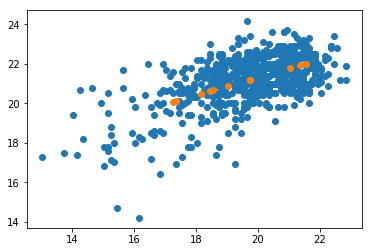

In [12]:
## repetim per minim
id_missing= train_iq[pd.isnull(train_iq['station_min_temp_c'])].index.tolist()
xx = train_iq['reanalysis_min_air_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
yy=train_iq['station_min_temp_c'].drop(id_missing,axis=0).values.reshape(-1,1)
xx_test=train_iq['reanalysis_min_air_temp_c'][id_missing].values.reshape(-1,1)

#predict
LR.fit(xx,yy)
pred=LR.predict(xx_test)

#plot
plt.scatter(xx,yy)
plt.scatter(xx_test,pred)
plt.show()

# ho posem on toca i fem un plot de la time series per veure com queda
df_TOTAL['station_min_temp_c'][id_missing] = pred[:,0]

### Omplim station_precip_mm 
    1- 'iq': posar el valor de precipitation_amt_mm --> el resultat es igual que el metode amb Ridge utilitzant aquest de predictor. (ens quedem amb aixo **facil i senzill**)
    2-  part, per ciutat 'sj', hi han alguns NaNs per precipitation_amt_mm i reanalisis_amt. Mirant les altres dues features de precipitation, veiem que la que te mes relacio es la reanalysis_precip_amt_kg_per_m2. La farem servir per imputar NaNs

In [13]:
# precipi per iq amb valor_amt_mm
id_missing= df_TOTAL[pd.isnull(df_TOTAL['station_precip_mm'])].index.tolist()
df_TOTAL['station_precip_mm'][id_missing]= df_TOTAL.loc[id_missing]['precipitation_amt_mm'].values


# precip_amt (sj) amb dades prcip reanalysis
id_missing= df_TOTAL[pd.isnull(df_TOTAL['precipitation_amt_mm'])].index.tolist()
df_TOTAL['precipitation_amt_mm'][id_missing]= df_TOTAL.loc[id_missing]['reanalysis_precip_amt_kg_per_m2'].values

# Per seguir fent coses ara tornem a separar entre localitzacions

In [14]:
df_iq = df_TOTAL[df_TOTAL['city']=='iq'] # aixo te train i test eh
df_sj = df_TOTAL[df_TOTAL['city']=='sj'] # aixo te train i test eh

#### ara per 'iq' nomes ens queda completar la variacio diurna de temperatura
mirem correlacions lineals.
* podem fre-ho complicat i aplicar model de regressio amb variables amb mes 0.5 de correlacio (per exemple) --> Ridgle
* podem fer una correlacio lineal tal qual (lineal regression nomes amb la station_max_temp_rng_c) --> 0.66 de correlacio

Fent LR nomes amb una variable dona un error de 0.9. Fent **Ridge** amb mes d'una tenim error absolut de 0.8. Fem aquest.

In [15]:
# omplim iq
features_train_num_test = ['station_diur_temp_rng_c','station_max_temp_c','reanalysis_max_air_temp_c','reanalysis_relative_humidity_percent','reanalysis_tdtr_k']
features_train_num_test_X =  ['station_max_temp_c','reanalysis_max_air_temp_c','reanalysis_relative_humidity_percent','reanalysis_tdtr_k']
train_rain0=df_iq.loc[:,features_train_num_test]

id_missing= train_rain0[pd.isnull(train_rain0['station_diur_temp_rng_c'])].index.tolist()

xx = train_rain0[features_train_num_test_X].drop(id_missing,axis=0).values

yy=train_rain0['station_diur_temp_rng_c'].drop(id_missing,axis=0).values.reshape(-1,1)

xx_test=train_rain0.loc[id_missing][features_train_num_test_X].values

from sklearn.linear_model import Ridge

Rlin= Ridge()

results = cross_val_score(Rlin, xx, yy, cv=6, scoring='neg_mean_absolute_error')
print('Mean absolute error Ridge:',(-results.mean()))

#predict
Rlin.fit(xx,yy)
pred=Rlin.predict(xx_test)


# ho posem on toca i fem un plot de la time series per veure com queda
df_iq['station_diur_temp_rng_c'][id_missing] = pred[:,0]

Mean absolute error Ridge: 0.7912942497060079


### Repassem NaNs

# provem interpolacio amb funcio time.
    1- per fer-ho hem de posar time al index primer
    2- aixo tb ho podriem haver fet amb totes le svariables previes..... (ho provarem en un altre)


In [16]:
df_iq = df_iq.reset_index().set_index('Date_Start_week')
df_sj = df_sj.reset_index().set_index('Date_Start_week')
df_iq.head()

,index,city,precipitation_amt_mm,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,...,station_precip_mm,total_cases,weekofyear,year,reanalysis_air_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,reanalysis_dew_point_temp_c,ndvi_N,ndvi_S
Date_Start_week,,,,,,,,,,,,,,,,,,,,,
2000-07-01,936,iq,25.41,43.19,92.418571,16.651429,8.928571,26.400000,10.775000,32.5,...,3.0,0.0,26,2000,23.590000,34.15,19.95,22.034286,0.162571,0.294043
2000-07-08,937,iq,60.61,46.00,93.581429,16.862857,10.314286,26.900000,11.566667,34.0,...,55.6,0.0,27,2000,23.484286,33.45,17.95,22.208571,0.246467,0.265557
2000-07-15,938,iq,55.52,64.77,95.848571,17.120000,7.385714,26.800000,11.466667,33.0,...,38.1,0.0,28,2000,23.265714,31.35,19.45,22.472857,0.174943,0.166064
2000-07-22,939,iq,5.60,23.96,87.234286,14.431429,9.114286,25.766667,10.533333,31.5,...,30.0,0.0,29,2000,22.207143,30.45,15.45,19.647143,0.186579,0.227257
2000-07-29,940,iq,62.76,31.80,88.161429,15.444286,9.500000,26.600000,11.480000,33.3,...,4.0,0.0,30,2000,23.282857,33.85,18.35,20.807143,0.325386,0.307707


In [17]:
df_iq['ndvi_N'] = df_iq['ndvi_N'].interpolate(method='time')
df_sj['ndvi_N'] = df_sj['ndvi_N'].interpolate(method='time')
df_sj['ndvi_S'] = df_sj['ndvi_S'].interpolate(method='time')

### Ara tornem a separar en train i test per cada ciutat

In [18]:
df_iq = df_iq.set_index('index')
df_sj = df_sj.set_index('index')

In [19]:
df_sj['precipitation_amt_mm_2week']=np.nan
df_sj['reanalysis_relative_humidity_percent_2week']=np.nan
df_sj['reanalysis_specific_humidity_g_per_kg_2week']=np.nan
df_sj['station_avg_temp_c_2week']=np.nan
df_sj['station_max_temp_c_2week']=np.nan

df_sj = df_sj.reset_index()

# ----------------------
df_iq['precipitation_amt_mm_2week']=np.nan
df_iq['reanalysis_relative_humidity_percent_2week']=np.nan
df_iq['reanalysis_specific_humidity_g_per_kg_2week']=np.nan
df_iq['station_avg_temp_c_2week']=np.nan
df_iq['station_max_temp_c_2week']=np.nan

df_iq = df_iq.reset_index()

In [20]:
for i in df_sj.index:
    if i>1:
        df_sj['precipitation_amt_mm_2week'][i]=df_sj.loc[i-2]['precipitation_amt_mm']
    if i>6:
        df_sj['reanalysis_relative_humidity_percent_2week'][i]=df_sj.loc[i-7]['reanalysis_relative_humidity_percent']
        df_sj['reanalysis_specific_humidity_g_per_kg_2week'][i]=df_sj.loc[i-7]['reanalysis_specific_humidity_g_per_kg']
        df_sj['station_avg_temp_c_2week'][i]=df_sj.loc[i-7]['station_avg_temp_c']
        df_sj['station_max_temp_c_2week'][i]=df_sj.loc[i-7]['station_max_temp_c']

In [21]:
for i in df_iq.index:
    if i>1:
        df_iq['precipitation_amt_mm_2week'][i]=df_iq.loc[i-2]['precipitation_amt_mm']
    if i>6:
        df_iq['reanalysis_relative_humidity_percent_2week'][i]=df_iq.loc[i-7]['reanalysis_relative_humidity_percent']
        df_iq['reanalysis_specific_humidity_g_per_kg_2week'][i]=df_iq.loc[i-7]['reanalysis_specific_humidity_g_per_kg']
        df_iq['station_avg_temp_c_2week'][i]=df_iq.loc[i-7]['station_avg_temp_c']
        df_iq['station_max_temp_c_2week'][i]=df_iq.loc[i-7]['station_max_temp_c']

In [22]:
df_sj['precipitation_amt_mm_2week'] = df_sj['precipitation_amt_mm_2week'].fillna(method='backfill')
df_sj['reanalysis_relative_humidity_percent_2week'] = df_sj['reanalysis_relative_humidity_percent_2week'].fillna(method='backfill')
df_sj['reanalysis_specific_humidity_g_per_kg_2week'] = df_sj['reanalysis_specific_humidity_g_per_kg_2week'].fillna(method='backfill')
df_sj['station_avg_temp_c_2week'] = df_sj['station_avg_temp_c_2week'].fillna(method='backfill')
df_sj['station_max_temp_c_2week'] = df_sj['station_max_temp_c_2week'].fillna(method='backfill')

df_iq['precipitation_amt_mm_2week'] = df_iq['precipitation_amt_mm_2week'].fillna(method='backfill')
df_iq['reanalysis_relative_humidity_percent_2week'] = df_iq['reanalysis_relative_humidity_percent_2week'].fillna(method='backfill')
df_iq['reanalysis_specific_humidity_g_per_kg_2week'] = df_iq['reanalysis_specific_humidity_g_per_kg_2week'].fillna(method='backfill')
df_iq['station_avg_temp_c_2week'] = df_iq['station_avg_temp_c_2week'].fillna(method='backfill')
df_iq['station_max_temp_c_2week'] = df_iq['station_max_temp_c_2week'].fillna(method='backfill')

In [37]:
df_sj = df_sj.set_index('index')
df_iq = df_iq.set_index('index')

In [38]:
# SJ
# per tornar a train i test, fem servir els labels (NaNs son test)
id_missing= df_sj[pd.isnull(df_sj['total_cases'])].index.tolist()

df_sj_train = df_sj.drop(id_missing,axis=0)
df_sj_train = df_sj_train.drop(columns=['total_cases','city','year'])

df_sj_test = df_sj.loc[id_missing]
df_sj_test = df_sj_test.drop(columns=['total_cases','city','year'])

df_sj_labels = train_labels_df[train_labels_df['city']=='sj']


# IQ
# per tornar a train i test, fem servir els labels (NaNs son test)
id_missing= df_iq[pd.isnull(df_iq['total_cases'])].index.tolist()

df_iq_train = df_iq.drop(id_missing,axis=0)
df_iq_train = df_iq_train.drop(columns=['total_cases','city','year'])

df_iq_test = df_iq.loc[id_missing]
df_iq_test = df_iq_test.drop(columns=['total_cases','city','year'])

df_iq_labels = train_labels_df[train_labels_df['city']=='iq']

# MODELS
## Apliquem un gradient XGBoost per veure importancia features

In [39]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from xgboost import plot_importance

In [40]:
model = XGBRegressor()
kfold = KFold(n_splits=10)

In [28]:
## iq

Mean Absolute error IQ: -7.054876997342072


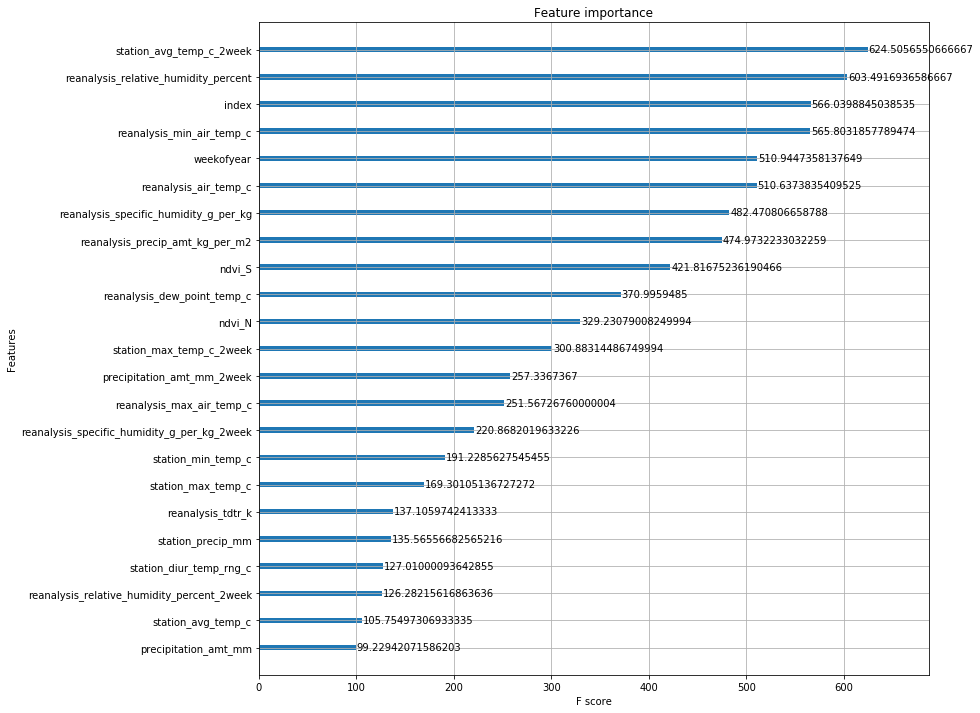

In [29]:
Xx_train=df_iq_train
yy_train=df_iq_labels['total_cases'].values

results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error IQ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

Mean Absolute error SJ: -25.04465121021194


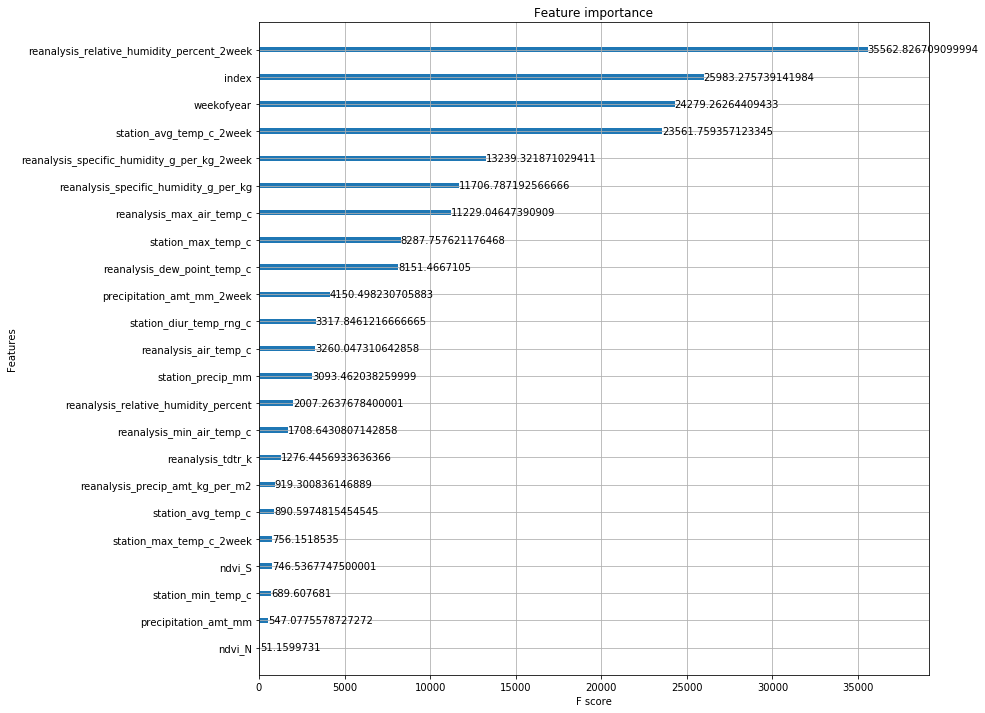

In [30]:
Xx_train=df_sj_train
yy_train=df_sj_labels['total_cases'].values

results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SJ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(12, 12))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

In [31]:
df_iq_train.columns

Index(['index', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'weekofyear',
       'reanalysis_air_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_dew_point_temp_c', 'ndvi_N',
       'ndvi_S', 'precipitation_amt_mm_2week',
       'reanalysis_relative_humidity_percent_2week',
       'reanalysis_specific_humidity_g_per_kg_2week',
       'station_avg_temp_c_2week', 'station_max_temp_c_2week'],
      dtype='object')

In [63]:
list_features_sj=['weekofyear','reanalysis_relative_humidity_percent_2week','reanalysis_specific_humidity_g_per_kg_2week',
                  'station_avg_temp_c_2week',
               'reanalysis_max_air_temp_c','reanalysis_specific_humidity_g_per_kg']


Xx_train=df_sj_train[list_features_sj]
yy_train=df_sj_labels['total_cases'].values

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))

Mean Absolute error SJ: -26.54427176483216


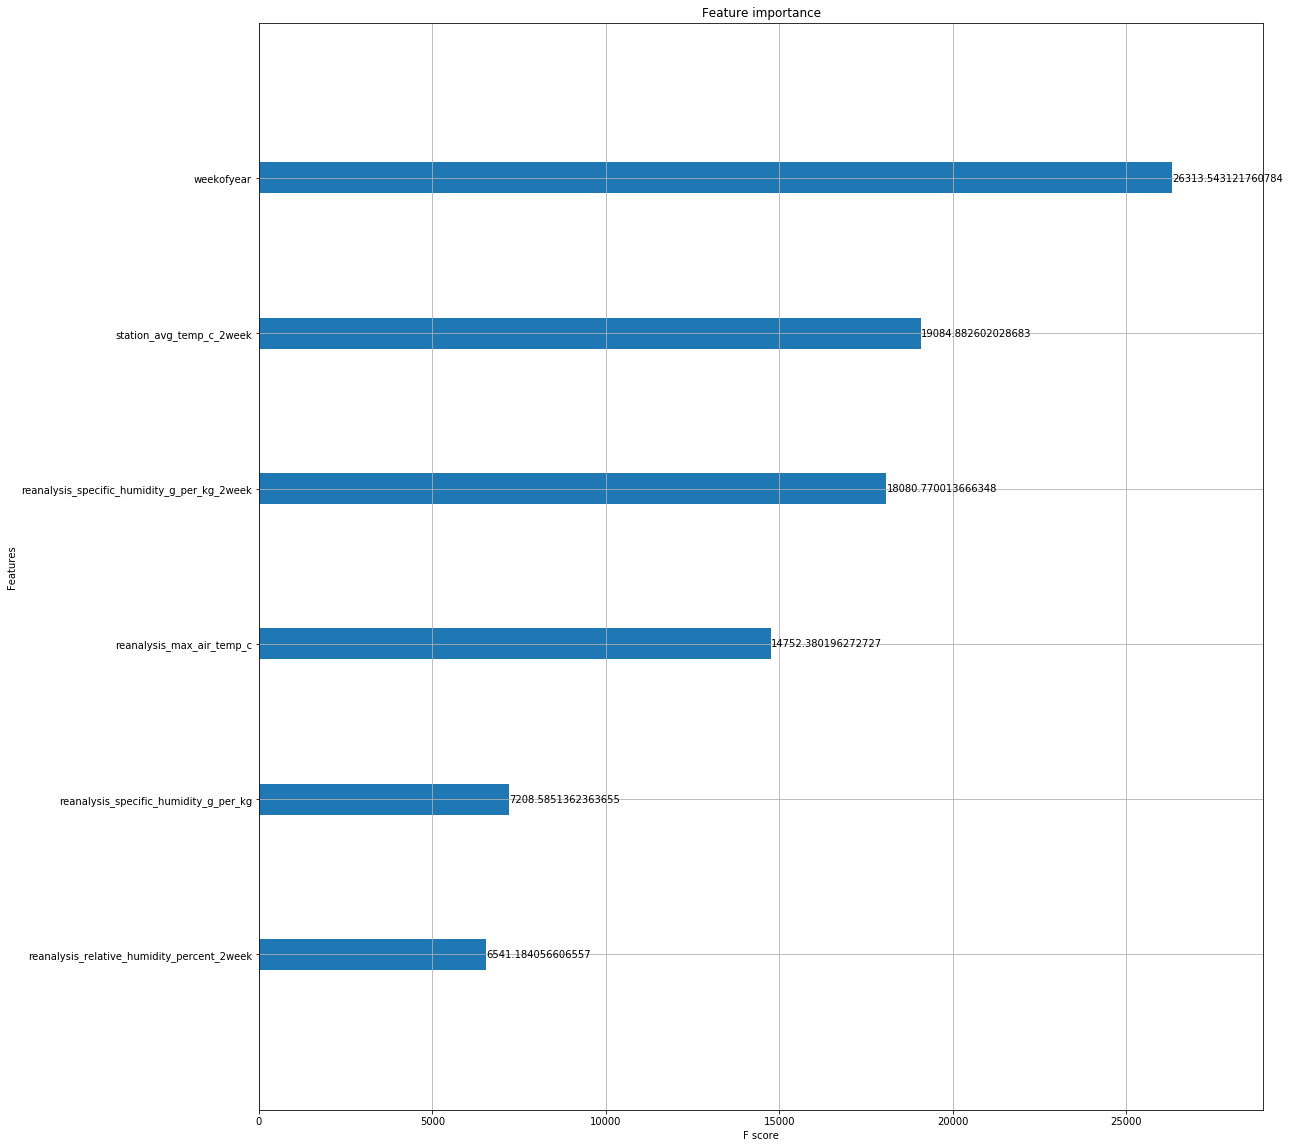

In [64]:
results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SJ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(18, 20))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

Mean Absolute error IQ: -7.645198031520502


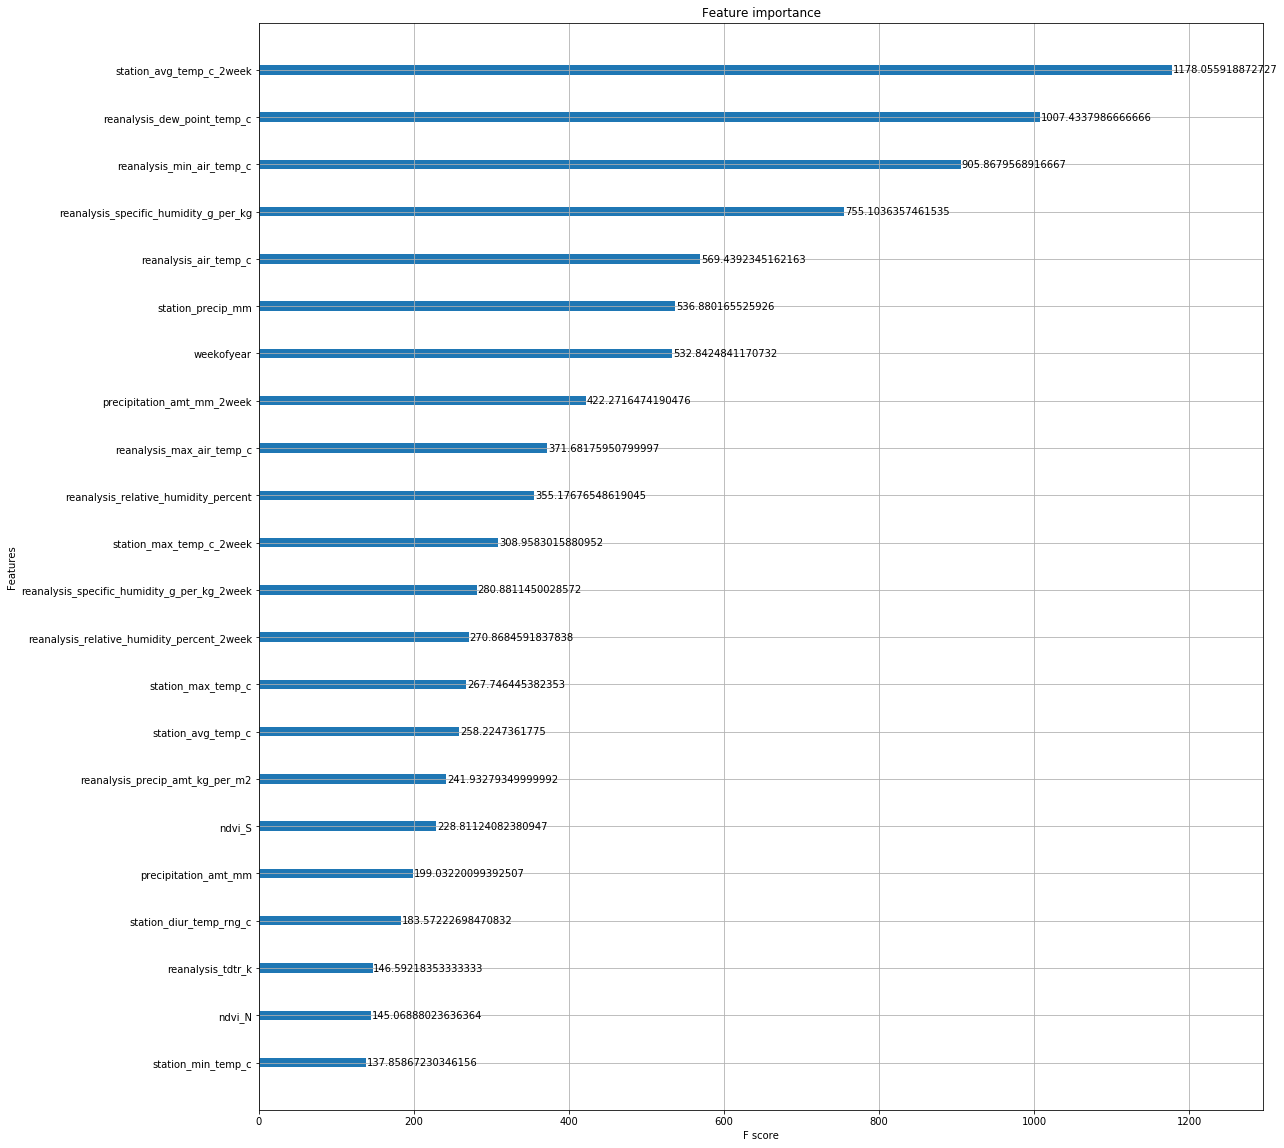

In [47]:
Xx_train=df_iq_train
yy_train=df_iq_labels['total_cases'].values

results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error IQ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(18, 20))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

In [48]:
df_iq_train.columns

Index(['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'weekofyear',
       'reanalysis_air_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_dew_point_temp_c', 'ndvi_N',
       'ndvi_S', 'precipitation_amt_mm_2week',
       'reanalysis_relative_humidity_percent_2week',
       'reanalysis_specific_humidity_g_per_kg_2week',
       'station_avg_temp_c_2week', 'station_max_temp_c_2week'],
      dtype='object')

In [50]:
list_features_iq=['reanalysis_min_air_temp_c','station_avg_temp_c_2week','reanalysis_dew_point_temp_c']


Xx_train=df_iq_train[list_features_iq]
yy_train=df_iq_labels['total_cases'].values

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))

Mean Absolute error IQ: -7.385765767315485


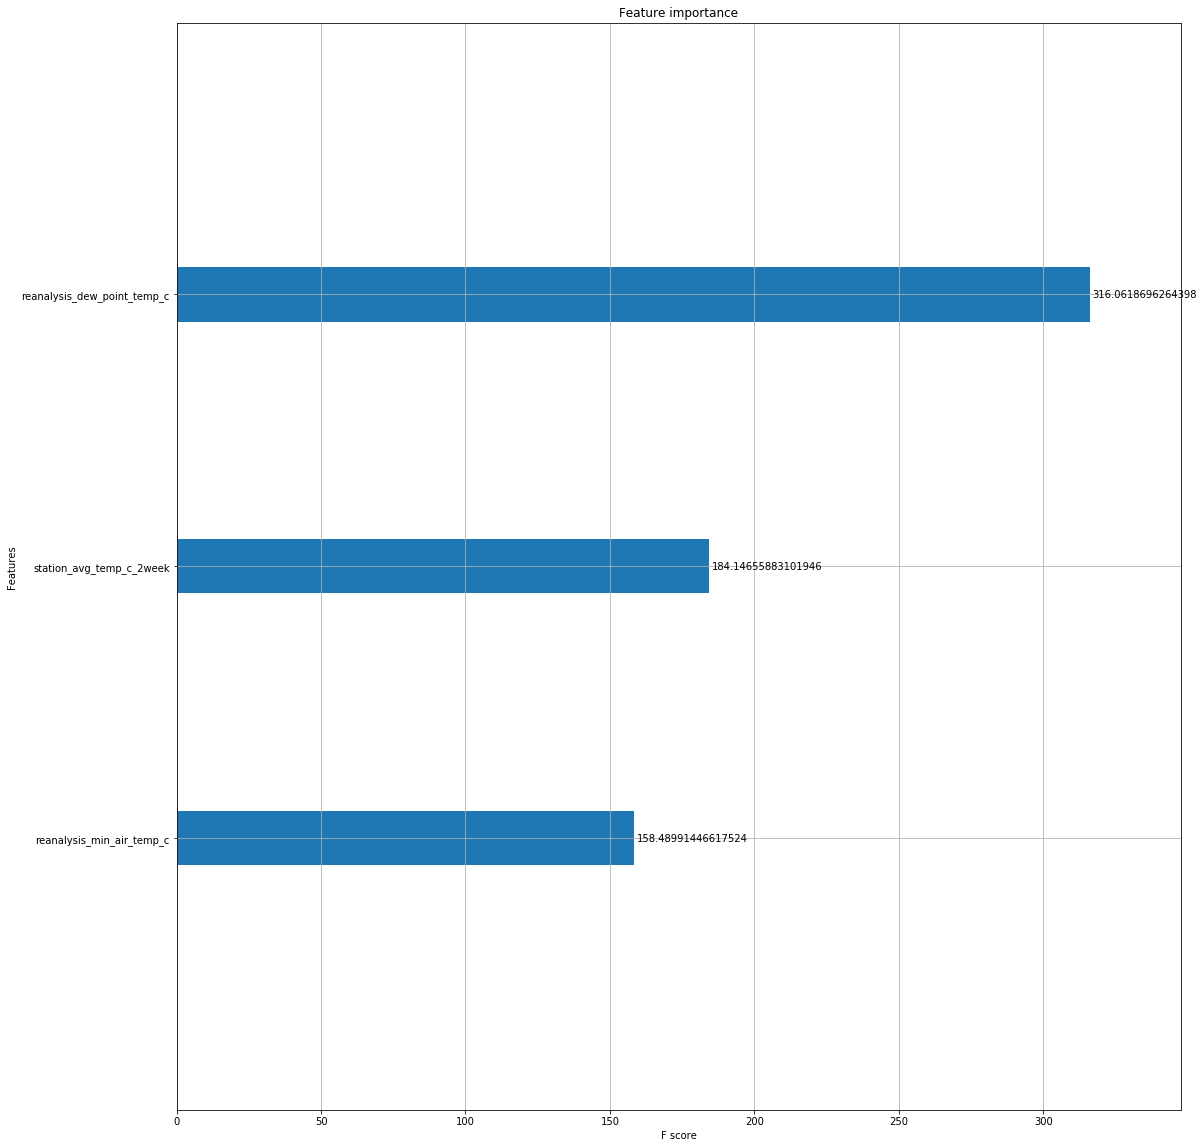

In [51]:
results = cross_val_score(model, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error IQ:", (results.mean()))
      
model.fit(Xx_train, yy_train)

# plot feature importance

_, ax = plt.subplots(1, 1, figsize=(18, 20))
plot_importance(model, ax=ax, importance_type='gain',max_num_features=60);
plt.show()

## A ) per IQ la millor solucio es amb una variable: 
    *'R3_reanalysis_min_air_temp_c'

## B) per SJ la millor te en compte diferents variables:
    * 

Aixo ho farem servir amb un model nou

In [65]:
from sklearn.svm import SVR

Xx_train=df_iq_train[list_features_iq]
yy_train=df_iq_labels['total_cases'].values

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    

modelSVR_iq = SVR(kernel='rbf', C= 20, coef0= 1, epsilon = .05) #en teoria ja hem fet hyperparametres, mateixosper rbf
results = cross_val_score(modelSVR_iq, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SVR per IQ amb una variable nomes:", (results.mean()))

Mean Absolute error SVR per IQ amb una variable nomes: -5.94002768854439


In [66]:
Xx_train=df_sj_train[list_features_sj]
yy_train=df_sj_labels['total_cases'].values


from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))

modelSVR_sj = SVR(kernel='rbf', C= 100, coef0= 10, epsilon = .05) #en teoria ja hem fet hyperparametres, mateixosper rbf
results = cross_val_score(modelSVR_sj, Xx_train, yy_train, cv=kfold, scoring='neg_mean_absolute_error', )
print("Mean Absolute error SVR per SJ amb una variable nomes:", (results.mean()))

Mean Absolute error SVR per SJ amb una variable nomes: -22.433906529592427


In [ ]:
## Preparem submision

In [67]:
list_features_sj

['weekofyear',
 'reanalysis_relative_humidity_percent_2week',
 'reanalysis_specific_humidity_g_per_kg_2week',
 'station_avg_temp_c_2week',
 'reanalysis_max_air_temp_c',
 'reanalysis_specific_humidity_g_per_kg']

In [ ]:
## using driven data model for sj

In [79]:
Xx_train=df_sj_train[list_features_sj]
Xx_test=df_sj_test[list_features_sj]

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))


kk11= pd.concat([Xx_train, df_sj_labels['total_cases']], axis=1, sort=False)
sj_train_subtrain = kk11.head(800)
sj_train_subtest = kk11.tail(df_sj_train.shape[0] - 800)

from statsmodels.tools import eval_measures
import statsmodels.api as sm
import statsmodels.formula.api as smf
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_relative_humidity_percent_2week +" \
                    "reanalysis_specific_humidity_g_per_kg_2week +" \
                    "station_avg_temp_c_2week + " \
                    "reanalysis_max_air_temp_c + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "weekofyear"
    
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)


best alpha =  1e-08
best score =  21.53846153846154


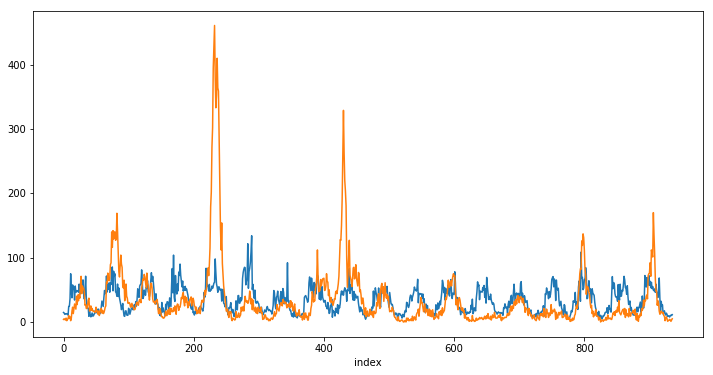

In [77]:
#figs, axes = plt.subplots(nrows=2, ncols=1)

plt.figure(figsize=(12,6))
kk11['fitted'] = sj_best_model.fittedvalues
kk11.fitted.plot(label="Predictions")
kk11.total_cases.plot(label="Actual")
plt.show()

In [70]:
list_features_iq

['reanalysis_min_air_temp_c',
 'station_avg_temp_c_2week',
 'reanalysis_dew_point_temp_c']

best alpha =  1e-08
best score =  6.698275862068965


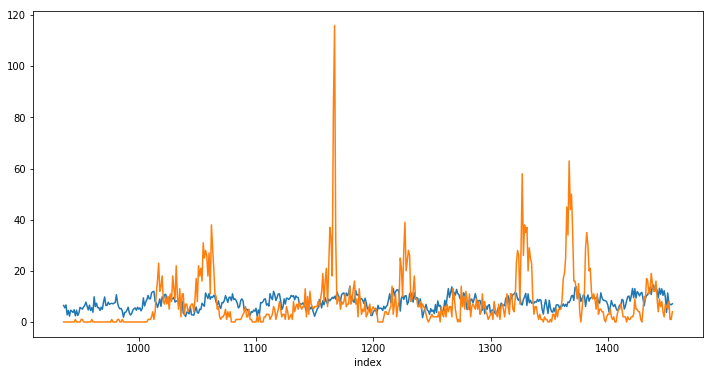

In [71]:
Xx_train=df_iq_train[list_features_iq]
Xx_test=df_iq_test[list_features_iq]

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))

kkiq= pd.concat([Xx_train, df_iq_labels['total_cases']], axis=1, sort=False)
iq_train_subtrain = kkiq.head(400)
iq_train_subtest = kkiq.tail(df_iq_train.shape[0] - 400)

from statsmodels.tools import eval_measures
import statsmodels.api as sm
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_min_air_temp_c +" \
                    "station_avg_temp_c_2week +" \
                    "reanalysis_dew_point_temp_c"
    
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

print (iq_best_model)

plt.figure(figsize=(12,6))
kkiq['fitted'] = iq_best_model.fittedvalues
kkiq.fitted.plot(label="Predictions")
kkiq.total_cases.plot(label="Actual")
plt.show()


In [73]:
model_formula_iq = "total_cases ~ 1 + " \
                    "reanalysis_min_air_temp_c +" \
                    "station_avg_temp_c_2week +" \
                    "reanalysis_dew_point_temp_c"


Xx_train=df_iq_train[list_features_iq]
Xx_test=df_iq_test[list_features_iq]

for i in list_features_iq:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))

model_iq = smf.glm(formula=model_formula_iq,
                    data=kkiq,
                    family=sm.families.NegativeBinomial(alpha=1e-08))
results_iq = model_iq.fit()

pred_iq_N = results_iq.predict(Xx_test)



model_formula_sj = "total_cases ~ 1 + " \
                    "reanalysis_relative_humidity_percent_2week +" \
                    "reanalysis_specific_humidity_g_per_kg_2week +" \
                    "station_avg_temp_c_2week + " \
                    "reanalysis_max_air_temp_c + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "weekofyear"

Xx_train=df_sj_train[list_features_sj]
Xx_test=df_sj_test[list_features_sj]

for i in list_features_sj:
    Xx_train[i]=min_max_scaler.fit_transform(np.array(Xx_train[i].values).reshape(-1,1))
    Xx_test[i]=min_max_scaler.fit_transform(np.array(Xx_test[i].values).reshape(-1,1))

model_sj = smf.glm(formula=model_formula_sj,
                    data=kk11,
                    family=sm.families.NegativeBinomial(alpha=1e-05))
results_sj = model_sj.fit()

pred_sj_N = results_sj.predict(Xx_test)

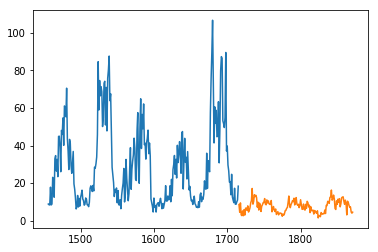

In [74]:
plt.plot(pred_sj_N)
plt.plot(pred_iq_N)

In [75]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([pred_sj_N.astype(int), pred_iq_N.astype(int)])
submission.to_csv("submision5.csv")

In [ ]:
df_sj_train.columns

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


x=df_sj_train['station_max_temp_c']
x2=df_sj_train['precipitation_amt_mm']
x3=df_sj_train['reanalysis_relative_humidity_percent']
x4=df_sj_train['reanalysis_specific_humidity_g_per_kg']
x5=df_sj_train['station_avg_temp_c']

y=df_sj_labels['total_cases'].values

plt.figure(figsize=(12,4))
plt.xcorr(x, y, usevlines=False, maxlags=15, normed=True, lw=2)
plt.xcorr(x2, y, usevlines=False, maxlags=15, normed=True, lw=2)
plt.xcorr(x3, y, usevlines=False, maxlags=15, normed=True, lw=2)
plt.xcorr(x4, y, usevlines=False, maxlags=15, normed=True, lw=2)
plt.xcorr(x5, y, usevlines=False, maxlags=15, normed=True, lw=2)
plt.grid(True)
plt.legend(('station_max_temp_c','precipitation_amt_mm','reanalysis_relative_humidity_percent',
            'reanalysis_specific_humidity_g_per_kg','station_min_temp_c'))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

Veiem clarament com hi ha un time_lag per algunes variables:
1. precipitation_amt_mm - 2
2. station_max_temp_c, reanalysis_relative_humidity_percent, reanalysis_specific_humidity_g_per_kg, station_min_temp_c -7/8

In [80]:
# ara afegim columna que sigui previous cases